## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the data

In [5]:
## Load the data
training_file = "/content/drive/MyDrive/German Traffic Signs/train.p"
testing_file = "/content/drive/MyDrive/German Traffic Signs/test.p"   
 
# Open and load the training file 
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
 
# Open and load the training file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
print("Data loaded")

Data loaded


## Data exploration

In [6]:
## let's create a pandas dataframe to load csv
## The content of csv file is ClassId and the SignName
 
sign_name_df = pd.read_csv('/content/drive/MyDrive/German Traffic Signs/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [7]:
# Define features and labels for training data 
X, y = train['features'], train['labels']
 
# Converting lists into numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)
 
# Define the features and labels for testing data
X_test, y_test = test['features'], test['labels']
 
# Converting lists into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


## Splitting data

In [8]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


# Data visualization

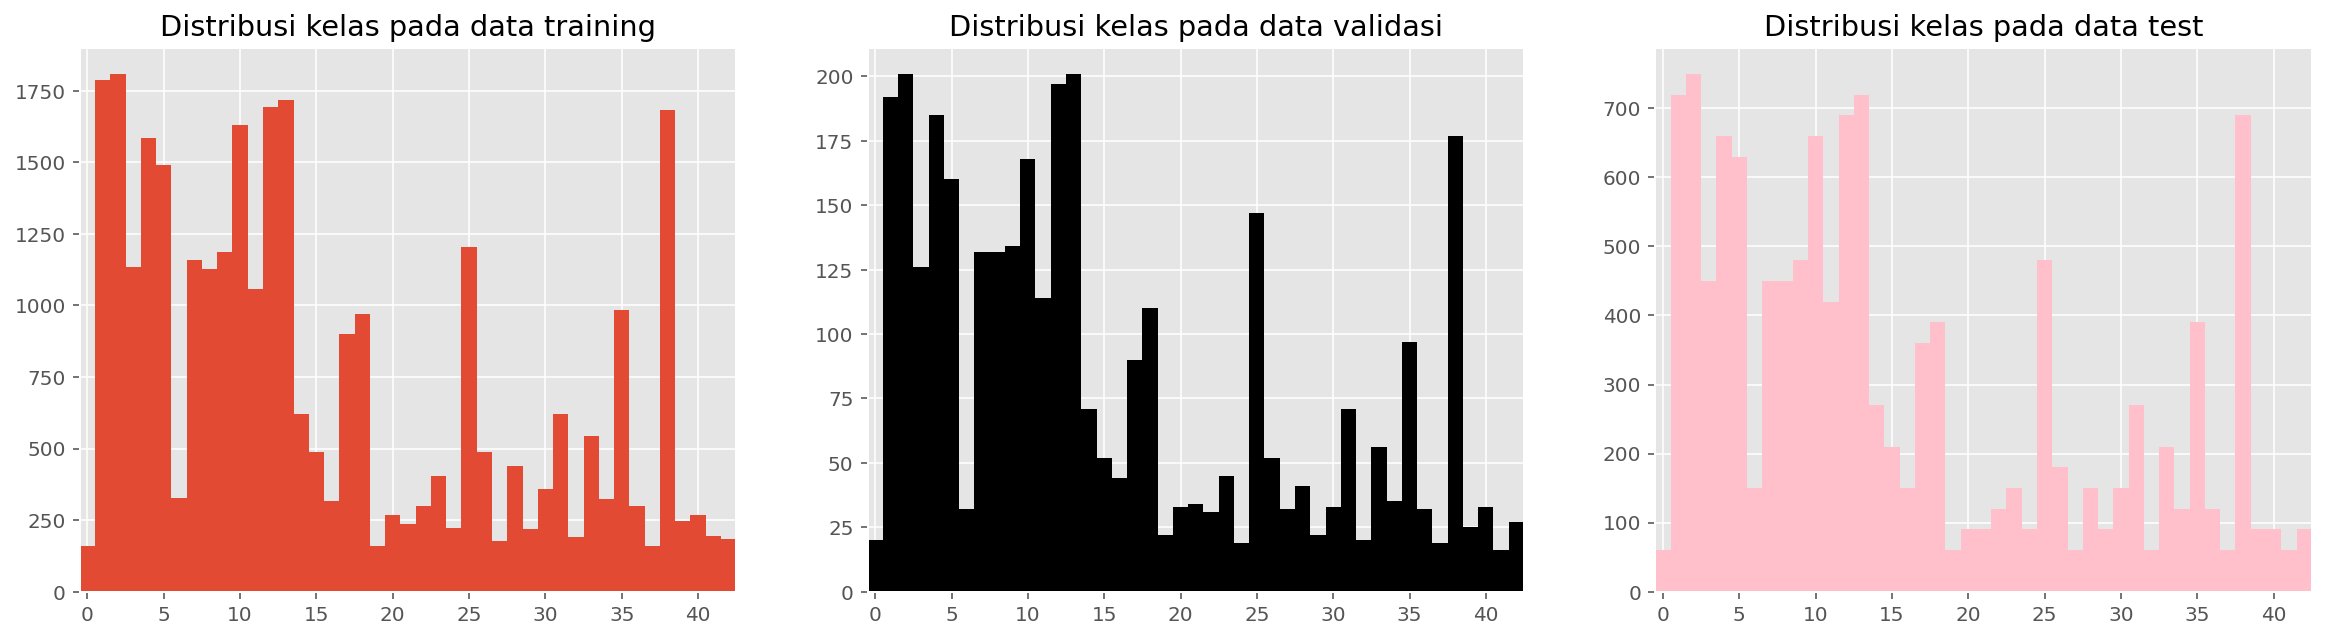

In [9]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)
        
fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='pink')

# Data preparation

In [10]:
# Converting the labels into one hot encoding
from tensorflow.keras.utils import to_categorical
 
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

## Creating callbacks

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

# Building model

In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 169s 171ms/step - loss: 1.5424 - accuracy: 0.6013 - val_loss: 0.2123 - val_accuracy: 0.9443
Epoch 2/25
979/979 [==============================] - 167s 171ms/step - loss: 0.3729 - accuracy: 0.8952 - val_loss: 0.0788 - val_accuracy: 0.9807
Epoch 3/25
979/979 [==============================] - 168s 171ms/step - loss: 0.2693 - accuracy: 0.9237 - val_loss: 0.1737 - val_accuracy: 0.9503
Epoch 4/25
979/979 [==============================] - 167s 171ms/step - loss: 0.2145 - accuracy: 0.9414 - val_loss: 0.0445 - val_accuracy: 0.9897
Epoch 5/25
979/979 [==============================] - 167s 170ms/step - loss: 0.2050 - accuracy: 0.9470 - val_loss: 0.0407 - val_accuracy: 0.9925
Epoch 6/25
979/979 [==============================] - 167s 171ms/step - loss: 0.2137 - accuracy: 0.9461 - val_loss: 0.0545 - val_accuracy: 0.9856
Epoch 7/25
979/979 [==============================] - 172s 175ms/step - loss: 0.2119 - accuracy: 0.9454 - val_loss: 0.0711 -

## Plotting

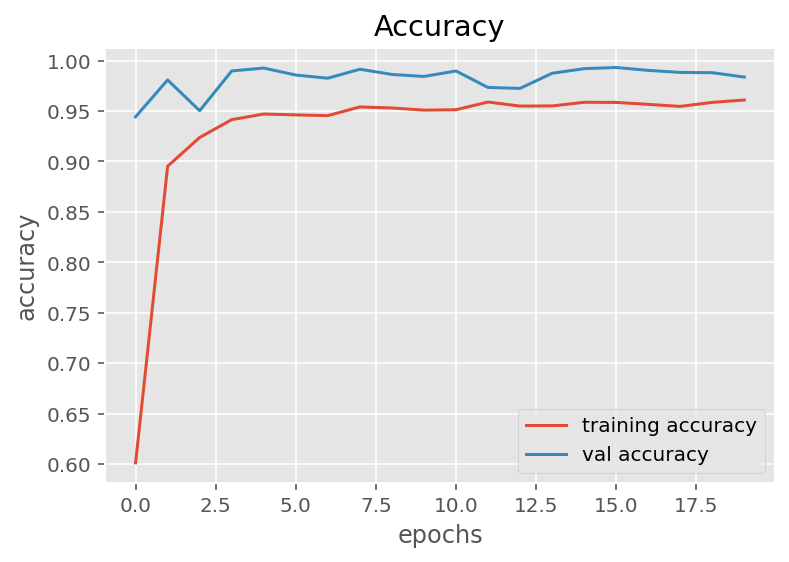

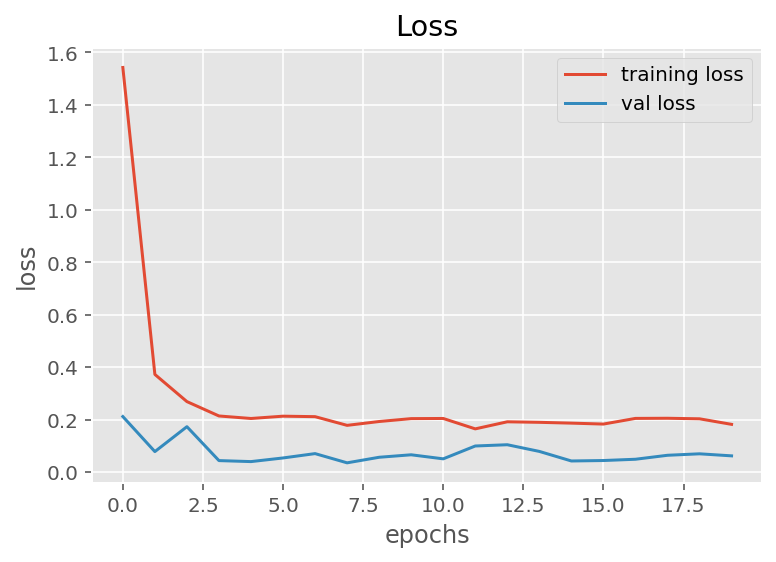

In [14]:
# Plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
 
# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Testing model

In [15]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score
 
pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

0.953840063341251

In [16]:
# Calculate metrics for classification
from sklearn.metrics import classification_report
 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.96      0.99      0.97       720
           2       0.96      0.98      0.97       750
           3       0.95      0.89      0.92       450
           4       0.98      0.96      0.97       660
           5       0.86      0.94      0.89       630
           6       0.99      0.87      0.93       150
           7       0.98      0.96      0.97       450
           8       0.95      0.97      0.96       450
           9       0.95      1.00      0.97       480
          10       0.99      0.98      0.99       660
          11       0.91      0.93      0.92       420
          12       0.99      0.95      0.97       690
          13       0.99      0.98      0.98       720
          14       1.00      1.00      1.00       270
          15       0.96      0.99      0.98       210
          16       1.00      0.99      1.00       150
          17       0.99    